In [2]:
import numpy as np
import matplotlib.pyplot as plt
fs = 1000
N=24
x1=10
dx = 1
du=1/75
cT_min = 50
cT_max = 400
delta_cT = 1
fmin = 1
fmax = 50
f_receiver = 4.5
p = 95
up_low_bounds = 'No'
Direction = 'Forward'
plot_dispersion_curve = 'Yes'
dispersion_curve = 'lambda_c'
Filename = 'SampleData.txt'
FigFontSize = 12
resolution = 100
LoadData = np.loadtxt('SampleData.txt', dtype='float',delimiter=None)

In [3]:
class dispersion_analysis(object):
    def __init__(self,fs,N,x1,dx,du,cT_min,cT_max,delta_cT,fmin,fmax,f_receiver):
        self.fs = fs
        self.N = N
        self.x1,self.dx = x1,dx
        self.du = du
        self.cT_min,self.cT_max = cT_min,cT_max
        self.delta_cT = delta_cT
        self.fmin,self.fmax,self.f_receiver = fmin,fmax,f_receiver
        u_read = np.loadtxt(Filename,dtype='float', delimiter=None)
        if Direction == 'Forward':
            self.u = u_read
        elif Direction == 'Backward':
            self.u = np.fliplr(u_read)
        else:
            print('Error')
        self.Tmax = (1/self.fs) * (len(self.u[:,0]) - 1)
        self.T = np.linspace(0,self.Tmax,len(self.u[:,0]))
        self.L = (self.N-1)*self.dx
        self.x = np.arange(self.x1,self.L+x1+1E-05,dx)
    def MASW_Despersion_imaging(self):
        omega_fs = 2*np.pi*self.fs
        Lu = len(self.u[:,0])
        U = np.zeros((Lu,self.N),dtype='complex')
        P = np.zeros((Lu,self.N),dtype='complex')
        Unorm = np.zeros((Lu,self.N),dtype='complex')
        for j in range(self.N):    
            U[:,j] = np.fft.fft(self.u[:,j])
        LU = len(U[:,0])
        for j in range(self.N):
            for k in range(int(LU)):
                Unorm[k,j] = U[k,j] / np.abs(U[k,j])
            P[:,j] = np.exp(1j*(-np.angle(U[:,j])))
        omega = (1/LU) * np.arange(0,LU+1,1)*omega_fs
        cT = np.arange(self.cT_min,self.cT_max+self.delta_cT,self.delta_cT)
        LcT = len(cT)
        self.c = np.zeros((LU, LcT))
        self.f = np.zeros((LU,LcT))
        self.A = np.zeros((LU,LcT))
        for j in range(int(LU)):
            for k in range(int(LcT)):
                self.f[j,k] = omega[j] / (2*np.pi)
                self.c[j,k] = cT[k]
                delta = omega[j]/cT[k]
                temp = 0
                for l in range(self.N):
                    temp = temp + np.exp(-1j*delta*self.x[l])*P[j,l]
                self.A[j,k] = np.abs(temp)/self.N
        RemoveMin = np.abs((self.f[:,0] - self.fmin))
        RemoveMax = np.abs((self.f[:,0] - self.fmax))
        IdxMin = np.array(np.where(RemoveMin==np.min(RemoveMin))).flatten()[0]
        IdxMax = np.array(np.where(RemoveMax==np.min(RemoveMax))).flatten()[0]
        self.Aplot = self.A[IdxMin:IdxMax+1,:]
        self.fplot = self.f[IdxMin:IdxMax+1,:]
        self.cplot = self.c[IdxMin:IdxMax+1,:]
        abs_norm = np.zeros((self.Aplot.shape))
        for i in range(len(self.Aplot[:,0])):
            abs_norm[i,:] = np.divide(self.Aplot[i,:],np.max(self.Aplot[i,:]))
        loc = np.argwhere(abs_norm.T == 1)
        self.c_loc = loc[:,0]
        self.f_loc = loc[:,1]
        Amax_fvec = np.zeros((len(self.f_loc)))
        Amax_cvec = np.zeros((len(self.c_loc)))
        for i in range(len(self.f_loc)):
            Amax_cvec[i] = self.cplot[0,self.c_loc[i]]
            Amax_fvec[i] = self.fplot[self.f_loc[i],0]   
        ii = np.where(Amax_fvec > self.f_receiver)
        Amax_cvec = Amax_cvec[ii]
        Amax_fvec = Amax_fvec[ii]
        jj = np.argsort(Amax_fvec)
        self.Amax_fvec_sort = Amax_fvec[jj]
        self.Amax_cvec_sort = Amax_cvec[jj]   
        lower_freq = 4
        higher_freq = 43
        nP0 = np.arange(lower_freq,higher_freq+1,1)
        self.f_curve0 = self.Amax_fvec_sort[nP0]
        self.c_curve0 = self.Amax_cvec_sort[nP0]
        self.lambda_curve0 = np.divide(self.c_curve0, self.f_curve0)     
        if up_low_bounds == 'yes':
            loc_p = np.argwhere(abs_norm.T > p/100)
            f_loc_p, c_loc_p = loc_p[:,1], loc_p[:,0]
            Amax_fvec_p = np.zeros((f_loc_p.shape))
            Amax_cvec_p = np.zeros((c_loc_p.shape))
            for i in range(len(f_loc_p)):                
                Amax_fvec_p[i] = self.fplot[f_loc_p[i], 0]
                Amax_cvec_p[i] = self.cplot[0,c_loc_p[i]]
            kk = np.where(Amax_fvec_p > self.f_receiver)
            Amax_fvec_p = Amax_fvec_p[kk]
            Amax_cvec_p = Amax_cvec_p[kk]
            pp = np.argsort(Amax_fvec_p)
            self.Amax_fvec_sort_p = Amax_fvec_p[pp]
            self.Amax_cvec_sort_p = Amax_cvec_p[pp]
            self.Amax_fvec_sort_p_cell = np.empty((len(np.unique(self.Amax_fvec_sort_p)), 1),dtype=object)
            self.Amax_cvec_sort_p_cell = np.empty((len(np.unique(self.Amax_fvec_sort_p)), 1),dtype=object)
            self.f_curve0_up_temp = np.zeros((len(np.unique(self.Amax_fvec_sort_p)),1))
            self.c_curve0_up_temp = np.zeros((len(np.unique(self.Amax_fvec_sort_p)),1))
            self.f_curve0_low_temp = np.zeros((len(np.unique(self.Amax_fvec_sort_p)),1))
            self.c_curve0_low_temp = np.zeros((len(np.unique(self.Amax_fvec_sort_p)),1))      
            U = np.unique(self.Amax_fvec_sort_p, return_index=False) ## return index's sorted order
            for i in range(len(U)):
                self.Amax_fvec_sort_p_cell[i][0] = self.Amax_fvec_sort_p[np.where(self.Amax_fvec_sort_p==U[i])]
                self.Amax_cvec_sort_p_cell[i][0] = self.Amax_cvec_sort_p[np.where(self.Amax_fvec_sort_p==U[i])]           
                self.f_curve0_up_temp[i] = np.max(self.Amax_fvec_sort_p_cell[i][0])
                self.c_curve0_up_temp[i] = np.max(self.Amax_cvec_sort_p_cell[i][0])
                self.f_curve0_low_temp[i] = np.min(self.Amax_fvec_sort_p_cell[i][0])
                self.c_curve0_low_temp[i] = np.min(self.Amax_cvec_sort_p_cell[i][0])
            self.f_curve0_up = self.f_curve0_up_temp[nP0]
            self.c_curve0_up = self.c_curve0_up_temp[nP0]
            self.f_curve0_low = self.f_curve0_low_temp[nP0]
            self.c_curve0_low = self.c_curve0_low_temp[nP0]
            self.lambda_curve0_up = np.divide(self.c_curve0_up, self.f_curve0_up)
            self.lambda_curve0_low = np.divide(self.c_curve0_low, self.f_curve0_low)
        if plot_dispersion_curve == 'Yes':
            SignalToPlot = np.zeros((len(self.u[:,0]),self.N),dtype='float')
            fig,ax = plt.subplots(figsize=(5,6))
            for j in range(N):
                SignalToPlot[:,j] = self.u[:,j] + j*self.du*self.dx     
                plt.plot(SignalToPlot[:,j],self.T,'k')
            ax.set_xlim(-5*self.dx*self.du,self.L*self.du+5*self.dx*self.du)
            ax.set_ylim(0,self.Tmax)
            ax.set_xlabel('Distance from source [m]', fontsize = FigFontSize)
            ax.set_ylabel('Time [s]', fontsize = FigFontSize)
            ax.set_xticks(np.arange(0,self.L*self.du+6*dx*self.du,6*dx*self.du))
            plt.gca().invert_yaxis()
            fig,ax = plt.subplots(figsize=(4,6))
            plt.contourf(self.cplot,self.fplot,self.Aplot,resolution,cmap=plt.cm.jet)    
            ax.plot(self.Amax_cvec_sort,self.Amax_fvec_sort,'o')   
            if up_low_bounds == 'yes':
                ax.plot(self.Amax_fvec_sort_p,self.Amax_cvec_sort_p,'--o',markersize=1,markerfacecolor='k',markeredgecolor='k')
                plt.plot(self.f_curve0_up_temp,self.c_curve0_up_temp, 'o',markersize=4,markerfacecolor='k',markeredgecolor='k')
                plt.plot(self.f_curve0_low_temp, self.c_curve0_low_temp,'o',markersize=4,markerfacecolor='k',markeredgecolor='k')
            ax.set_xlabel('Phase velocity [m/s]',fontsize = FigFontSize)
            ax.set_ylabel('Frequency (Hz)',fontsize = FigFontSize)
            plt.gca().invert_yaxis()
            cbar = plt.colorbar(orientation='horizontal',location='top')
            cbar.set_label('Normalized amplitude', fontsize = FigFontSize)
            labels = np.arange(1,len(self.Amax_fvec_sort)+1,1)
            for i, addtext in enumerate(labels):
                ax.annotate(addtext, (self.Amax_fvec_sort[i],self.Amax_cvec_sort[i]),horizontalalignment='right',\
                    verticalalignment='bottom')
            fig,ax = plt.subplots(figsize=(4,6))
            if dispersion_curve == 'f_c':
                ax.plot(self.f_curve0,self.c_curve0,'o-')
                if up_low_bounds == 'yes':
                    ax.plot(self.f_curve0_up,self.c_curve0_up,'r+--')
                    ax.plot(self.f_curve0_low,self.c_curve0_low,'r+--')
                ax.set_xlabel('Frequency (Hz)', fontsize = FigFontSize)
                ax.set_ylabel('Reyleigh wave velocity [m/s]', fontsize = FigFontSize)
                ax.legend(['Fundamental DC','Upper BC','Lower BC'],loc='upper right')
            if dispersion_curve == 'lambda_c':
                ax.plot(self.c_curve0,self.lambda_curve0, 'o-')
                if up_low_bounds == 'yes':
                    ax.plot(self.c_curve0_up,self.lambda_curve0_up,'r+--')
                    ax.plot(self.c_curve0_low,self.lambda_curve0_low,'r+--')
                plt.gca().invert_yaxis()
                ax.set_xlabel('Reyleigh wave velocity [m/s]',fontsize = FigFontSize)
                ax.set_ylabel('Wavelength [m]', fontsize = FigFontSize)
                ax.legend(['Fundamental DC','Upper BC','Lower BC'],loc='upper right')
            plt.show()
        return self.lambda_curve0

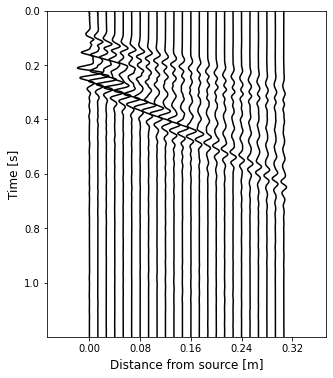

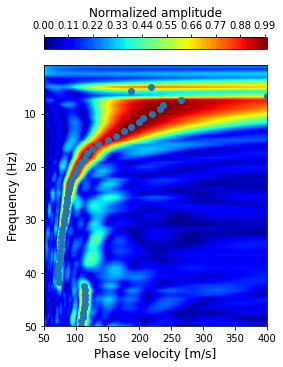

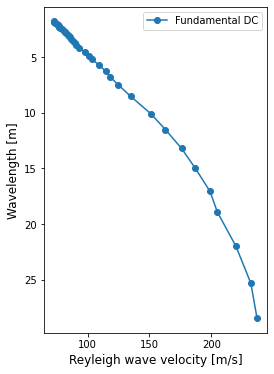

In [4]:
dispersion = dispersion_analysis(fs,N,x1,dx,du,cT_min,cT_max,delta_cT,fmin,fmax,f_receiver)
lambda_curve0 = dispersion.MASW_Despersion_imaging()

In [12]:
c_test_min = 1
c_test_max = 500
delta_c_test = 0.5
c_test = np.arange(c_test_min,c_test_max+delta_c_test,delta_c_test)
n = 6
alpha = np.array([1400,1400,1400,1400,1400,1400,1400])
h = np.array([1,1,2,2,4,5,np.inf])
beta = np.array([75,90,150,180,240,290,290])
rho = [1850,1850,1850,1850,1850,1850,1850]


In [18]:
def theorectical_dispersion_curve(c_test,Lambda,h,alpha,beta,rho,n):
    k = 2*np.pi/Lambda
    Det = np.zeros((len(k),len(c_test)),dtype='object')
    c_t = np.zeros((len(k),1))
    lambda_t = np.zeros((len(k),1))
    for l in range(len(k)):
        for m in range(len(c_test)):
            Det[l,m] = stiffness_matrix(c_test[m],k[l],h,alpha,beta,rho,n)
            if m==0:
                sign_old = np.sign(Det[l,m])
            else:
                sign_old = signD
            signD = np.sign(Det[l,m])
            if sign_old*signD == -1:
                c_t[l] = c_test[m]
                lambda_t[l] = 2*np.pi/k[l]
                print(c_t)
                break
    return c_t,lambda_t
c_t,lambda_t = theorectical_dispersion_curve(c_test,lambda_curve0,h,alpha,beta,rho,n)

def stiffness_matrix(c_test,k,h,alpha,beta,rho,n):
    K = np.zeros((2*(n+1),2*(n+1)))
    eps = 0.0001
    while any(abs(c_test-beta) < eps) or any(abs(c_test-alpha) < eps):
        c_test = c_test*(1-eps)
    for j in range(n):
        Ke = layer_stiffness_matrix(h[j],alpha[j],beta[j],rho[j],c_test,k)
        DOFs = np.arange(2*(j+0),2*(j+2),1)
        for row in DOFs:
            for col in DOFs:
                row_idx = np.array(np.where(DOFs==row)).flatten()[0]
                col_idx = np.array(np.where(DOFs==col)).flatten()[0]
                K[row,col] = K[row,col] + Ke[row_idx,col_idx]
    Ke_halfspace = layer_stiffness_matrix_halfspace(alpha[-1],beta[-1],rho[-1],c_test,k)
    DOFs = np.arange(2*n,2*(n+1),1)
    for row in DOFs:
        for col in DOFs:
            row_idx = np.array(np.where(DOFs==row)).flatten()[0]
            col_idx = np.array(np.where(DOFs==col)).flatten()[0]
            K[row,col] = K[row,col] + Ke_halfspace[row_idx,col_idx]
    D = np.real(np.linalg.det(K))
    return D
def layer_stiffness_matrix(h,alpha,beta,rho,c_test,k):
    r = np.sqrt(1-c_test**2/alpha**2)
    s = np.sqrt(1-c_test**2/beta**2)
    Cr = np.cosh(k*r*h)
    Sr = np.sinh(k*r*h)
    Cs = np.cosh(k*s*h)
    Ss = np.sinh(k*s*h)
    D = 2*(1-Cr*Cs) + (1/(r*s) + r*s)*Sr*Ss
    k11_e = (k*rho*c_test**2)/D * (s**(-1)*Cr*Ss - r*Sr*Cs)
    k12_e = (k*rho*c_test**2)/D * (Cr*Cs - r*s*Sr*Ss - 1) - k*rho*beta**2*(1+s**2)
    k13_e = (k*rho*c_test**2)/D * (r*Sr - s**(-1)*Ss)
    k14_e = (k*rho*c_test**2)/D * (-Cr + Cs)
    k21_e = k12_e
    k22_e = (k*rho*c_test**2)/D * (r**(-1)*Sr*Cs - s*Cr*Ss)
    k23_e = -k14_e
    k24_e = (k*rho*c_test**2)/D * (-r**(-1)*Sr + s*Ss)
    k31_e = k13_e
    k32_e = k23_e
    k33_e = k11_e
    k34_e = -k12_e
    k41_e = k14_e
    k42_e = k24_e
    k43_e = -k21_e
    k44_e = k22_e
    Ke = np.array([[k11_e, k12_e, k13_e, k14_e],
                    [k21_e, k22_e, k23_e, k24_e],
                    [k31_e, k32_e, k33_e, k34_e],
                    [k41_e, k42_e, k43_e, k44_e]])
    return Ke

def layer_stiffness_matrix_halfspace(alpha,beta,rho,c_test,k):
    r = np.sqrt(1-c_test**2/alpha**2)
    s = np.sqrt(1-c_test**2/beta**2)
    k_11 = k*rho*beta**2*(r*(1-s**2))/(1-r*s)
    k_12 = k*rho*beta**2*(1-s**2)/(1-r*s) - 2*k*rho*beta**2
    k_21 = k_12
    k_22 = k*rho*beta**2*(s*(1-s**2))/(1-r*s)
    Ke_halfspace = np.array([[k_11,k_12],
                            [k_21, k_22]])
    return Ke_halfspace

/tmp/ipykernel_3652/2705275400.py:47: RuntimeWarning: invalid value encountered in sqrt
  s = np.sqrt(1-c_test**2/beta**2)
/home/tranquockinh/.local/lib/python3.8/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/tmp/ipykernel_3652/2705275400.py:77: RuntimeWarning: invalid value encountered in sqrt
  s = np.sqrt(1-c_test**2/beta**2)


In [75]:
class seismic_backward(object):
    def __init__(self,num_layers,shear_wave,thickness,p_wave,unit_weight,c_test_array):
        self.n = num_layers
        self.alpha = shear_wave
        self.h = thickness
        self.beta = p_wave
        self.rho = unit_weight
        self.c_test = c_test_array
        self.forward = dispersion_analysis(fs,N,x1,dx,du,cT_min,cT_max,delta_cT,fmin,fmax,f_receiver)
        self.forward.read_data()
        self.wavelength = self.forward.extract_dispersion_curve()
        self.wavenumber = (2*np.pi)/(self.wavelength)
    def layer_stiffness_matrix(self,h,alpha,beta,rho,c_test,k):
        r = np.sqrt(1-c_test**2/alpha**2)
        s = np.sqrt(1-c_test**2/beta**2)
        Cr = np.cosh(k*r*h)
        Sr = np.sinh(k*r*h)
        Cs = np.cosh(k*s*h)
        Ss = np.sinh(k*s*h)
        D = 2*(1-Cr*Cs) + (1/(r*s) + r*s)*Sr*Ss
        k11_e = (k*rho*c_test**2)/D * (s**(-1)*Cr*Ss - r*Sr*Cs)
        k12_e = (k*rho*c_test**2)/D * (Cr*Cs - r*s*Sr*Ss - 1) - k*rho*beta**2*(1+s**2)
        k13_e = (k*rho*c_test**2)/D * (r*Sr - s**(-1)*Ss)
        k14_e = (k*rho*c_test**2)/D * (-Cr + Cs)
        k21_e = k12_e
        k22_e = (k*rho*c_test**2)/D * (r**(-1)*Sr*Cs - s*Cr*Ss)
        k23_e = -k14_e
        k24_e = (k*rho*c_test**2)/D * (-r**(-1)*Sr + s*Ss)
        k31_e = k13_e
        k32_e = k23_e
        k33_e = k11_e
        k34_e = -k12_e
        k41_e = k14_e
        k42_e = k24_e
        k43_e = -k21_e
        k44_e = k22_e
        Ke = np.array([[k11_e, k12_e, k13_e, k14_e],
                       [k21_e, k22_e, k23_e, k24_e],
                       [k31_e, k32_e, k33_e, k34_e],
                       [k41_e, k42_e, k43_e, k44_e]])
        return Ke
   
    def layer_stiffness_matrix_halfspace(self,alpha,beta,rho,c_test,k):
        r = np.sqrt(1-c_test**2/alpha**2)
        s = np.sqrt(1-c_test**2/beta**2)
        k_11 = k*rho*beta**2*(r*(1-s**2))/(1-r*s)
        k_12 = k*rho*beta**2*(1-s**2)/(1-r*s) - 2*k*rho*beta**2
        k_21 = k_12
        k_22 = k*rho*beta**2*(s*(1-s**2))/(1-r*s)
        Ke_halfspace = np.array([[k_11,k_12],
                                 [k_21, k_22]])
        return Ke_halfspace

    # def calculate_Ke(self):
    #     for j in range(1):
    #         h = self.h[j]
    #         alpha = self.alpha[j]
    #         beta = self.beta[j]
    #         rho = self.rho[j]
    #         c_test_input = self.c_test[j]
    #         k = self.wavenumber[j]
    #         alpha_hs = self.alpha[-1]
    #         beta_hs = self.beta[-1]
    #         rho_hs = self.rho[-1]
    #         c_test_input_hs = self.c_test[j]
    #         k_hs = self.wavenumber[j]
    #         Ke = self.layer_stiffness_matrix(h,alpha,beta,rho,c_test_input,k)
    #         Ke_halfspace = self.layer_stiffness_matrix_halfspace(alpha_hs,beta_hs,rho_hs,c_test_input_hs,k_hs)
    #     return Ke,Ke_halfspace

    def stiffness_matrix(self,c_test,k,h,alpha,beta,rho,n):
        K = np.zeros((2*(n+1),2*(n+1)))
        eps = 0.0001
        while any(abs(c_test-beta) < eps) or any(abs(c_test-alpha) < eps):
            c_test = c_test*(1-eps)
        for j in range(n):
            Ke = self.layer_stiffness_matrix(h[j],alpha[j],beta[j],rho[j],c_test,k)
            DOFs = np.arange(2*(j+0),2*(j+2),1)
            for row in DOFs:
                for col in DOFs:
                    row_idx = np.array(np.where(DOFs==row)).flatten()[0]
                    col_idx = np.array(np.where(DOFs==col)).flatten()[0]
                    K[row,col] = K[row,col] + Ke[row_idx,col_idx]
        Ke_halfspace = self.layer_stiffness_matrix_halfspace(alpha[-1],beta[-1],rho[-1],c_test,k)
        DOFs = np.arange(2*(n+0),2*(n+2),1)
        for row in DOFs:
            for col in DOFs:
                row_idx = np.array(np.where(DOFs==row)).flatten()[0]
                col_idx = np.array(np.where(DOFs==col)).flatten()[0]
                K[row,col] = K[row,col] + Ke_halfspace[row_idx,col_idx]
        D = np.real(np.linalg.det(K))
    def theorectical_dispersion_curve(self,c_test,h,alpha,beta,rho,n):
        c_test = self.c_test
        h = self.h
        alpha = self.alpha
        beta = self.beta
        rho = self.rho
        n = self.n
        k = self.wavenumber
        D = np.zeros((len(k),len(c_test)))
        c_t = np.zeros((len(k),1))
        lambda_t = np.zeros((len(k),1))
        for l in range(len(k)):
            for m in range(len(c_test)):
                D[l,m] = self.stiffness_matrix(c_test[m],k[l],h,alpha,beta,rho,n)
                if m==1:
                    sign_old = np.sign(D[l,m])
                else:
                    sign_old = signD
                signD = np.sign(D[l,m])
                if sign_old*signD == -1:
                    c_t[l] = c_test[m]
                    lambda_t[l] = 2*np.pi*(1/k[l])
                    break
        return 


In [36]:
# backward_calculation = seismic_backward(num_layers,shear_wave,thickness,p_wave,unit_weight,c_test_array)
# print(backward_calculation.theorectical_dispersion_curve(c_test_array,thickness,shear_wave,p_wave,unit_weight,num_layers))